# 머신러닝 기반 네이버 영화 리뷰 감성 분석

In [97]:
# 데이터셋 로딩하여 사용 (정수 인코딩을 한 feature vector)
import numpy as np
X_train = np.load('DataSet_NaverMovieReview/X_train_IE.npy')
X_test = np.load('DataSet_NaverMovieReview/X_test_IE.npy')
y_train = np.load('DataSet_NaverMovieReview/y_train_IE.npy')
y_test = np.load('DataSet_NaverMovieReview/y_test_IE.npy')

In [2]:
len(X_train), len(y_train), len(X_test), len(y_test)

(145162, 145162, 48745, 48745)

## Decision Tree
- criterion : 분할 기준 ['gini', 'entropy']
- splitter : 노드를 분할하는 데 사용되는 전략 ['best', 'random']
- max_depth': 트리의 최대 깊이
- min_samples_split : 노드 분할을 위한 최소 샘플 수 (2 ~)
- min_samples_leaf : 리프 노드에 필요한 최소 샘플 수 (1 ~)
- max_features : 각 분할에서 고려할 특성의 최대 수
    - [None, 'auto', 'sqrt', 'log2']
- class_weight: [None, 'balanced']
- random_state : 무작위성을 조절하기 위한 시드 값
    - 같은 시드로 모델을 학습하면 항상 동일한 결과를 얻을 수 있음    

In [28]:
from sklearn.tree import DecisionTreeClassifier
# 모델 초기화 (학습에 필요한 하이퍼 파라미터 설정)
DT_model = DecisionTreeClassifier(random_state=100, min_samples_split = 10)

In [29]:
# 모델 학습 (training set)
DT_model.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=10, random_state=100)

In [30]:
# 모델 성능 측정 (train set, test set)
train_score_DT = round(DT_model.score(X_train, y_train) * 100, 2)
test_score_DT = round(DT_model.score(X_test, y_test) * 100, 2)
train_score_DT, test_score_DT

(92.08, 64.1)

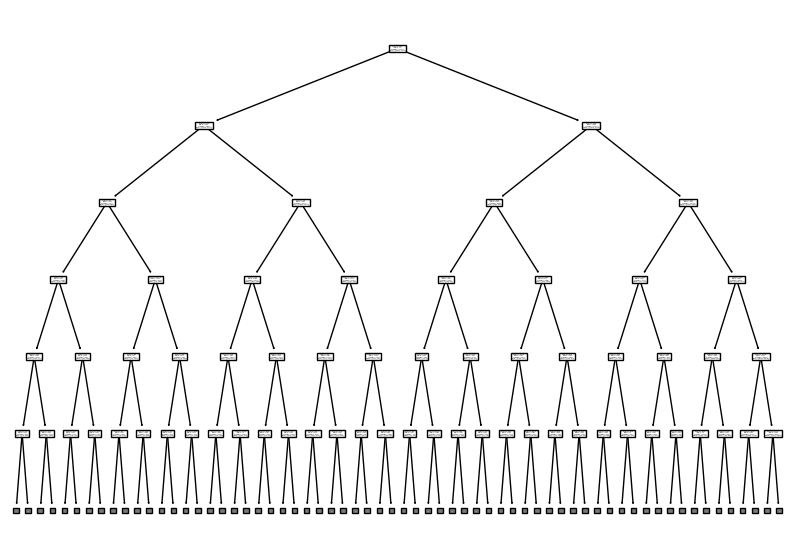

In [14]:
# Decision Tree 그려보기
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10,7))
plot_tree(DT_model, max_depth=5)
plt.show()

## 랜덤 포레스트 (Random Forrest)
- n_estimators : Dectsion Tree의 수 (기본 100개)
- bootstrap (True)
  - Bootstrap Sampling : 학습 데이터에서 데이터를 중복해서 샘플링하는 방식
- n_jobs (1) : 병렬처리에 사용할 CPU 코어의 수

In [34]:
# 모델 초기화
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_jobs = 4)

In [35]:
# 모델 학습
RF_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=4)

In [36]:
# 모델 성능 측정
train_score_RF = round(RF_model.score(X_train, y_train) * 100, 2)
test_score_RF = round(RF_model.score(X_test, y_test) * 100, 2)
train_score_RF, test_score_RF

(99.74, 64.94)

In [49]:
from konlpy.tag import Okt
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def okt_sw_rm_tokenize(sentence):
    tok_sent = okt.morphs(sentence, stem=True) # 토큰화
    sw_rm_sent = [word for word in tok_sent if word not in stopwords]
    return sw_rm_sent

In [54]:
# 학습 시 사용한 토크나이저(정수 인코딩을 하기위한 word_index를 생성)를 사용할 수 있도록 만들어 줌
# 정한 vocab_size로 toknizer를 다시 생성하여 word_index 생성
import pandas as pd
train_data = pd.read_json('DataSet_NaverMovieReview/train_data_prep.json')
X_train_text = list(train_data['tokenized'])
vocab_size = 19416
from tensorflow.keras.preprocessing.text import Tokenizer
k_tokenizer = Tokenizer(vocab_size)
k_tokenizer.fit_on_texts(X_train_text)

In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
max_len = 30

def analyze_sentiment(in_sent, model):
    # 한글과 공백을 제외한 문자 삭제 -> string
    in_sent_fv = re.sub(r'[^ ㄱ-ㅣ가-힣]+', "", in_sent)
    # 토큰화 및 불용어 제거 -> 1차원 array
    in_sent_fv = okt.morphs(in_sent_fv, stem=True) # 토큰화
    in_sent_fv = [word for word in in_sent_fv if word not in stopwords] # 불용어 제거
    # 정수 인코딩 -> 2차원 array로 만들어서 입력
    in_sent_fv = k_tokenizer.texts_to_sequences([in_sent_fv])
    # 패딩
    in_sent_fv = pad_sequences(in_sent_fv, maxlen = max_len)
    result = model.predict(in_sent_fv)
    return result

## LogisticRegression (로지스틱 회귀분석)
- penalty (default='l2'):규제 (Regularization)의 종류 지정
    - 'l1', 'l2', 'elasticnet', 'none'
    - 모델의 복잡도를 제어하고, 과적합(Overfitting)을 방지하는 기술
    - 모델의 가중치(weight)나 계수(coefficient)에 페널티를 부과하여 모델이 너무 복잡해지지 않도록 제한하는 역할
- C (default=1.0): 규제 강도 조절. 값이 작을수록 강한 규제가 적용
- fit_intercept (default=True):
- max_iter (default=100): 최적화 알고리즘이 수렴할 때까지 반복하는 최대 횟수
- random_state (default=None): 무작위성을 조절하기 위한 시드 값
- tol (default=1e-4): 수렴 기준으로, 손실 함수의 변화가 이 값보다 작을 때 최적화를 중단
- verbose (default=0): 최적화 과정 중에 출력을 활성화하려면 1 이상의 값을 지정
- warm_start (default=False): 이전에 학습된 모델을 초기화하지 않고 이어서 학습할 때 True로 설정

In [103]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(random_state=10)

In [104]:
LR_model.fit(X_train, y_train)

LogisticRegression(random_state=10)

In [105]:
# 모델 성능 측정
train_score_LR = round(LR_model.score(X_train, y_train) * 100, 2)
test_score_LR = round(LR_model.score(X_test, y_test) * 100, 2)
train_score_LR, test_score_LR

(51.18, 50.54)

In [102]:
in_sent = input("영화 리뷰를 입력하세요 :")
result = analyze_sentiment(in_sent, LR_model)
print(result)
print("긍정 리뷰입니다") if result > 0.5 else print("부정 리뷰입니다")

영화 리뷰를 입력하세요 :영화가 너무 졸립다
[0]
부정 리뷰입니다


## SVM 모델
* penalty (default='l2')
* C (default=1.0):
* loss (default='squared_hinge'): 손실 함수 지정
    - 'hinge' : 힌지 손실, 'squared_hinge' : 힌지 손실의 제곱
* random_state
* max_iter
* tol

In [106]:
from sklearn.svm import LinearSVC
SVM_model = LinearSVC()

In [107]:
SVM_model.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [108]:
# 모델 성능 측정
train_score_SVM = round(SVM_model.score(X_train, y_train) * 100, 2)
test_score_SVM = round(SVM_model.score(X_test, y_test) * 100, 2)
train_score_SVM, test_score_SVM

(50.55, 50.76)

## 퍼셉트론 모델 (인공신경망)
* penalty (default=None):
* alpha (default=0.0001): 규제 강도를 조절. 높을 수록 강한 규제
* max_iter (default=1000)
* tol (default=1e-3)
* shuffle (default=True): 각 에포크(epoch)마다 훈련 데이터를 섞을지 여부
* eta0 (default=1.0): 학습률
* random_state (default=0)

In [109]:
from sklearn.linear_model import Perceptron
NN_model = Perceptron()

In [110]:
NN_model.fit(X_train, y_train)

Perceptron()

In [112]:
def get_score(model):
    train_score = round(model.score(X_train, y_train) * 100, 2)
    test_score = round(model.score(X_test, y_test) * 100, 2)
    print(train_score, test_score)

In [113]:
get_score(NN_model)

49.97 50.17


## 나이브 베이지안
- 데이터가 가우시안 분포를 따른다고 가정을 따르면 일반적으로 데이터의 특성에 맞춰 잘 동작

In [117]:
from sklearn.naive_bayes import GaussianNB
NB_model = GaussianNB()

In [118]:
NB_model.fit(X_train, y_train)

GaussianNB()

In [119]:
get_score(NB_model)

50.73 50.86


## K-Nearest Neighbor (KNN)
- n_neighbors (default=5): 이웃의 개수(k)
- weights (default='uniform'):예측에 사용되는 가중치를 지정
    - uniform : 균일한 가중치
    - distance :
- algorithm (default='auto'): 이웃을 찾기 위해 사용되는 알고리즘
    - 'auto', 'ball_tree', 'kd_tree', 'brute'
- leaf_size (default=30): BallTree 또는 KDTree 알고리즘을 사용할 경우 잎 노드의 크기
- p (default=2): 거리 측정에 사용되는 매개변수
    - p=1 : 맨해튼 거리, p=2 : 유클리디안 거리
- metric (default='minkowski'):거리 측정에 사용되는 메트릭
    - 'minkowski'를 선택하면 p 매개변수에 따라 선택
- metric_params (default=None): 사용자 지정 거리 메트릭 함수에 대한 추가 매개변수
- n_jobs (default=None): 이웃을 검색하는 동안 사용되는 CPU 수. None = 1개

In [124]:
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_jobs=5, n_neighbors=3)

In [125]:
KNN_model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=5, n_neighbors=3)

In [126]:
train_score = round(KNN_model.score(X_train, y_train) * 100, 2)
test_score = round(KNN_model.score(X_test, y_test) * 100, 2)
print(train_score, test_score)

76.35 53.3
